In [79]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [80]:
df = pd.read_csv('data/anpc-2016-preprocessed-normalized.csv')
df=df.dropna()
df=df.drop('Unnamed: 0',axis=1)

In [81]:
df

,Latitude,Longitude,NumeroMeiosTerrestresEnvolvidos,NumeroOperacionaisTerrestresEnvolvidos,NumeroMeiosAereosEnvolvidos,NumeroOperacionaisAereosEnvolvidos,DuracaoEvento,AnoOcorrencia,MesOcorrencia,DiaOcorrencia,HoraOcorrencia,Grouped_Acidentes,Grouped_Assistência e Prevenção,Grouped_Incêndios,Grouped_Incêndios em Bens,Grouped_Operações,Grouped_Segurança e Serviços,Distrito_AVEIRO,Distrito_BEJA,Distrito_BRAGA,Distrito_BRAGANÇA,Distrito_CASTELO BRANCO,Distrito_COIMBRA,Distrito_FARO,Distrito_GUARDA,Distrito_LEIRIA,Distrito_LISBOA,Distrito_PORTALEGRE,Distrito_PORTO,Distrito_SANTARÉM,Distrito_SETÚBAL,Distrito_VIANA DO CASTELO,Distrito_VILA REAL,Distrito_VISEU,Distrito_ÉVORA
0,4.046329e-05,0.998153,0.002941,0.001382,0.0,0.0,0.479019,2016,9,1,14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1.709563e-05,0.998249,0.005882,0.001843,0.0,0.0,0.478863,2016,1,24,18,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.473458e-05,0.998263,0.002941,0.000922,0.0,0.0,0.478893,2016,2,13,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.938745e-05,0.998110,0.002941,0.000922,0.0,0.0,0.478919,2016,3,14,19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,9.887218e-05,0.998270,0.005882,0.003226,0.0,0.0,0.478996,2016,3,14,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120725,1.730769e-05,0.998175,0.002941,0.000922,0.0,0.0,0.478917,2016,12,31,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
120726,7.052604e-05,0.998269,0.002941,0.000922,0.0,0.0,0.479013,2016,12,31,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
120727,9.807244e-05,0.998200,0.002941,0.000922,0.0,0.0,0.478851,2016,12,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
120728,3.411055e-07,0.998265,0.008824,0.003687,0.0,0.0,0.478832,2016,12,31,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [82]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import torch

# define the features and target variables
features = df.drop(['NumeroMeiosTerrestresEnvolvidos', 'NumeroOperacionaisTerrestresEnvolvidos'], axis=1)
target = df[['NumeroMeiosTerrestresEnvolvidos', 'NumeroOperacionaisTerrestresEnvolvidos']]

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train=torch.from_numpy(X_train.to_numpy()).float()
X_test=torch.from_numpy(X_test.to_numpy()).float()
y_train=torch.from_numpy(y_train.to_numpy()).float()
y_test=torch.from_numpy(y_test.to_numpy()).float()


In [83]:
len(X_train)

96583

In [84]:
len(X_test)

24146

In [85]:
y_train

tensor([[0.0029, 0.0009],
        [0.0029, 0.0009],
        [0.0029, 0.0009],
        ...,
        [0.0029, 0.0009],
        [0.0029, 0.0009],
        [0.0029, 0.0009]])

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim

class MyModel(nn.Module):
    def __init__(self, input_dim=33, hidden_dim=48, output_dim=2):
        super(MyModel, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.hidden3 = nn.Linear(hidden_dim//2, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = torch.relu(self.hidden2(x))
        x = self.sigmoid(self.hidden3(x))
        return x
    
    def init_params(self, default_initialization=False):
            if not default_initialization:
                for name, p in self.named_parameters():
                    if p.dim() > 1:
                        nn.init.xavieruniform(p)

In [87]:
!pip install torchsummary

In [88]:
from torchsummary import summary

# set the random seed for reproducibility
torch.manual_seed(42)

# create the model
model = MyModel()
# print the model summary
summary(model, (33,))

model.train()



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 48]           1,632
            Linear-2                   [-1, 24]           1,176
            Linear-3                    [-1, 2]              50
           Sigmoid-4                    [-1, 2]               0
Total params: 2,858
Trainable params: 2,858
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


MyModel(
  (hidden): Linear(in_features=33, out_features=48, bias=True)
  (hidden2): Linear(in_features=48, out_features=24, bias=True)
  (hidden3): Linear(in_features=24, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [89]:
# set up the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# train the model
num_epochs = 50
batch_size = 32
num_batches = len(X_train) // batch_size
for epoch in range(num_epochs):
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch_x = X_train[start_idx:end_idx]
        batch_y = y_train[start_idx:end_idx]
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, torch.max(batch_y, 1)[1])
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = torch.sum(predicted == torch.max(y_test, 1)[1]).item() / len(y_test)
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, num_epochs, loss.item(), accuracy * 100))

Epoch [1/50], Loss: 0.3133, Accuracy: 99.93%
Epoch [2/50], Loss: 0.3133, Accuracy: 99.93%
Epoch [3/50], Loss: 0.3133, Accuracy: 99.93%
Epoch [4/50], Loss: 0.3133, Accuracy: 99.93%


KeyboardInterrupt: 

In [90]:
model(X_train[0])

tensor([1., 0.], grad_fn=<SigmoidBackward>)

In [93]:
y_train

tensor([[0.0029, 0.0009],
        [0.0029, 0.0009],
        [0.0029, 0.0009],
        ...,
        [0.0029, 0.0009],
        [0.0029, 0.0009],
        [0.0029, 0.0009]])

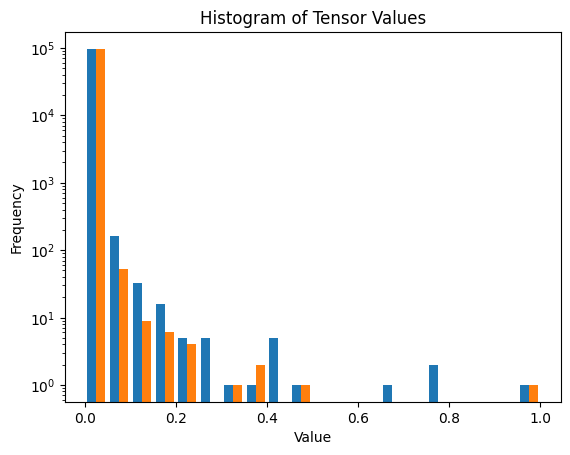

In [97]:
import matplotlib.pyplot as plt
# convert the tensor to a NumPy array
y_train_np = y_train.numpy()

# create a histogram of the values
plt.hist(y_train_np, bins=20)
plt.title('Histogram of Tensor Values')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()